# Importing Libraries
We are mainly using openCV, keras, tensorflow libraries for this research. The purpose of this research is to find out the best performing model than can classify shoplifiting from videos and provide alert signals to the shop incharges to prevent this outlaw. We are going to try our best to find the best model and parameter that will show case the best performance.  

### The models that we will try out are
- VGG16 (224 x 224 x 3)
- VGG19 (224 x 224 x 3)
- ResNet50 (224 x 224 x 3)
- InceptionV3 (299 x 299 x 3)
- Xception (299 x 299 x 3)

The first task is to import the libraries - 

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as p
import imutils

from scipy import ndimage
from moviepy.editor import *
from PIL import Image
from tqdm import tqdm

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications import ResNet50, VGG16, VGG19, DenseNet121
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import RMSprop, Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, ZeroPadding2D, BatchNormalization, Activation, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn import preprocessing

In [2]:
outputmodelpath = r'model/'
outputbinarizerpath = r'model/'

We are declaring some paths to save our **model** and **binarizer**. Now, we will start our preprocessing. The first step is to load the **images correctly**.


# Preprocessing

In [3]:
DATA_DIR = './ToImg'
CATEGORIES = ['Shoplifting', 'Normal_Activity']

IMG_SIZE = 224
data = []
labels = []

print("Images are being loaded...")

for c in CATEGORIES:
    path = os.path.join(DATA_DIR, c)
    class_num = CATEGORIES.index(c)
    
    for img in  tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_COLOR)
            img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            data.append([img_resized, class_num])
        except Exception as e:
            pass


print("--------------------------")
print("Images loaded successfully!")
print(f"Found {len(data)} images and {len(labels)} labels from {len(CATEGORIES)} Categories")
#data = np.array(data)

Images are being loaded...


100%|██████████████████████████████████████████████████████████████████████████████| 1663/1663 [00:16<00:00, 99.09it/s]

--------------------------
Images loaded successfully!
Found 2553 images and 0 labels from 2 Categories


# Visualizing the images for visual assessment of the data

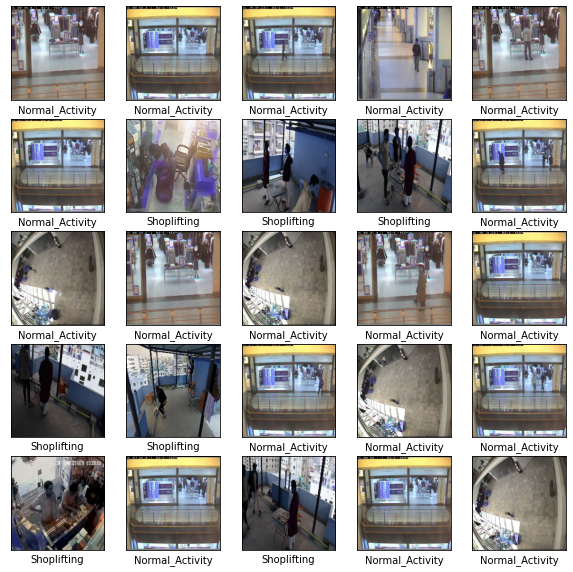

In [4]:
np.random.shuffle(data)

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(data[i][0])
    plt.xlabel(CATEGORIES[data[i][1]])
plt.show()


# Splitting the Data into train and test splits

In [5]:
lb = preprocessing.LabelBinarizer()

x = []
y = []

# print(x)

for i in range(len(data)):
    x.append(data[i][0])
    y.append(data[i][1])

x = np.array(x)
y = np.array(y)

y = lb.fit_transform(y)

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, stratify = y, random_state=42)

# Augmenting the data for better training

In [6]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                              rotation_range=40,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              fill_mode='nearest')
train_gen = train_datagen.flow(train_x, train_y, batch_size=32)


validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_gen = validation_datagen.flow(test_x, test_y)

# Model Creation - ResNet50

In [159]:
baseModel = ResNet50(weights="imagenet", include_top = False, input_tensor = Input(shape=(224,224,3)))

headModel = baseModel.output
headModel = MaxPooling2D(pool_size=(7,7))(headModel)
headModel = Flatten(name="Flatten")(headModel)
headModel = Dense(100, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(50, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(25, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)
model01 = Model(inputs=baseModel.input, outputs=headModel)

for basemodellayers in baseModel.layers:
    basemodellayers.trainable = False

In [160]:
# opt = Adam(learning_rate=0.0001)
opt = RMSprop(learning_rate=0.01)
model01.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [161]:
History01 = model01.fit_generator(
    train_gen,
    steps_per_epoch = len(train_x)//32,
    validation_data = validation_gen,
    validation_steps = len(test_x)//32,
    epochs = 20
)

Epoch 1/20
63/63 [==============================] - 406s 6s/step - loss: 1.4684 - accuracy: 0.6249 - val_loss: 0.6500 - val_accuracy: 0.6458
Epoch 2/20
63/63 [==============================] - 405s 6s/step - loss: 0.6655 - accuracy: 0.6507 - val_loss: 0.6466 - val_accuracy: 0.6521
Epoch 3/20
63/63 [==============================] - 405s 6s/step - loss: 0.6473 - accuracy: 0.6527 - val_loss: 0.6439 - val_accuracy: 0.6562
Epoch 4/20
63/63 [==============================] - 405s 6s/step - loss: 0.6673 - accuracy: 0.6488 - val_loss: 0.6453 - val_accuracy: 0.6542
Epoch 5/20
63/63 [==============================] - 405s 6s/step - loss: 0.6463 - accuracy: 0.6527 - val_loss: 0.6437 - val_accuracy: 0.6562
Epoch 6/20
63/63 [==============================] - 404s 6s/step - loss: 0.6477 - accuracy: 0.6498 - val_loss: 0.6480 - val_accuracy: 0.6500
Epoch 7/20
63/63 [==============================] - 404s 6s/step - loss: 0.6465 - accuracy: 0.6522 - val_loss: 0.6474 - val_accuracy: 0.6500
Epoch 8/20
63

In [163]:
score = model01.evaluate(test_x, test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6065715551376343
Test accuracy: 0.7377690672874451


# Model Creation - VGG16

In [69]:
baseModel = VGG16(weights="imagenet", include_top = False, input_tensor = Input(shape=(224,224,3)))

headModel = baseModel.output
headModel = MaxPooling2D(pool_size=(7,7))(headModel)
headModel = Flatten(name="Flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)
model02 = Model(inputs=baseModel.input, outputs=headModel)

for basemodellayers in baseModel.layers:
    basemodellayers.trainable = False

In [70]:
opt = SGD(learning_rate=0.01)
model02.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [71]:
History02 = model02.fit_generator(
    train_gen,
    steps_per_epoch = len(train_x)//32,
    validation_data = validation_gen,
    validation_steps = len(test_x)//32,
    epochs = 20
)

Epoch 1/20
63/63 [==============================] - 411s 7s/step - loss: 0.7007 - accuracy: 0.6299 - val_loss: 0.4571 - val_accuracy: 0.8562
Epoch 2/20
63/63 [==============================] - 474s 8s/step - loss: 0.5401 - accuracy: 0.7144 - val_loss: 0.3053 - val_accuracy: 0.9750
Epoch 3/20
63/63 [==============================] - 437s 7s/step - loss: 0.4149 - accuracy: 0.8129 - val_loss: 0.1837 - val_accuracy: 0.9854
Epoch 4/20
63/63 [==============================] - 431s 7s/step - loss: 0.3196 - accuracy: 0.8667 - val_loss: 0.1115 - val_accuracy: 0.9833
Epoch 5/20
63/63 [==============================] - 409s 6s/step - loss: 0.2449 - accuracy: 0.9060 - val_loss: 0.0740 - val_accuracy: 0.9812
Epoch 6/20
63/63 [==============================] - 404s 6s/step - loss: 0.2010 - accuracy: 0.9199 - val_loss: 0.0527 - val_accuracy: 0.9833
Epoch 7/20
63/63 [==============================] - 401s 6s/step - loss: 0.1585 - accuracy: 0.9418 - val_loss: 0.0739 - val_accuracy: 0.9750
Epoch 8/20
63

In [76]:
score = model02.evaluate(test_x, test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 4.093893527984619
Test accuracy: 0.9217221140861511


# Model Creation - VGG19

In [164]:
baseModel = VGG19(weights="imagenet", include_top = False, input_tensor = Input(shape=(224,224,3)))

headModel = baseModel.output
headModel = MaxPooling2D(pool_size=(7,7))(headModel)
headModel = Flatten(name="Flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)
model03 = Model(inputs=baseModel.input, outputs=headModel)

for basemodellayers in baseModel.layers:
    basemodellayers.trainable = False

In [165]:
opt = SGD(learning_rate=0.01)
model03.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
History03 = model03.fit_generator(
    train_gen,
    steps_per_epoch = len(train_x)//32,
    validation_data = validation_gen,
    validation_steps = len(test_x)//32,
    epochs = 20
)

Epoch 1/20
63/63 [==============================] - 1837s 29s/step - loss: 0.3096 - accuracy: 0.8652 - val_loss: 0.1833 - val_accuracy: 0.9625
Epoch 2/20
63/63 [==============================] - 1831s 29s/step - loss: 0.2784 - accuracy: 0.8766 - val_loss: 0.1412 - val_accuracy: 0.9500
Epoch 3/20
63/63 [==============================] - 1829s 29s/step - loss: 0.2292 - accuracy: 0.9060 - val_loss: 0.1095 - val_accuracy: 0.9583
Epoch 4/20
63/63 [==============================] - 1836s 29s/step - loss: 0.1859 - accuracy: 0.9428 - val_loss: 0.0990 - val_accuracy: 0.9667
Epoch 5/20
63/63 [==============================] - 1855s 29s/step - loss: 0.1773 - accuracy: 0.9383 - val_loss: 0.0837 - val_accuracy: 0.9708
Epoch 6/20
63/63 [==============================] - 1781s 28s/step - loss: 0.1579 - accuracy: 0.9438 - val_loss: 0.0793 - val_accuracy: 0.9688
Epoch 7/20
63/63 [==============================] - 1800s 29s/step - loss: 0.1435 - accuracy: 0.9443 - val_loss: 0.0715 - val_accuracy: 0.9708

In [ ]:
score = model03.evaluate(test_x, test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Model Creation - InceptionV3

In [109]:
baseModel = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(299,299,3)), pooling='avg')

headModel = baseModel.output
headModel = Flatten(name="Flatten")(headModel)
headModel = Dense(1024, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)
model04 = Model(inputs=baseModel.input, outputs=headModel)

for basemodellayers in baseModel.layers:
    basemodellayers.trainable = False

In [110]:
opt = SGD(learning_rate=0.01)
model04.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [112]:
History04 = model04.fit_generator(
    train_gen,
    steps_per_epoch = len(train_x)//32,
    validation_data = validation_gen,
    validation_steps = len(test_x)//32,
    epochs = 2
)

Epoch 1/2
63/63 [==============================] - 184s 3s/step - loss: 0.0723 - accuracy: 0.9910 - val_loss: 0.0651 - val_accuracy: 0.9958
Epoch 2/2
63/63 [==============================] - 200s 3s/step - loss: 0.0487 - accuracy: 0.9940 - val_loss: 0.0431 - val_accuracy: 0.9979


In [118]:
score = model04.evaluate(test_x, test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 9.589848518371582
Test accuracy: 0.3483366072177887


# Model Creation - Custom CNN

In [27]:
model = Sequential()
# The first two layers with 32 filters of window size 3x3
model.add(Conv2D(100, (3, 3), padding='same', activation='relu', input_shape=(224,224,3)))
model.add(Conv2D(100, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(50, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(50, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(25, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(25, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(25, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

opt = SGD(learning_rate=0.1)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
History05 = model.fit_generator(
    train_gen,
    steps_per_epoch = len(train_x)//32,
    validation_data = validation_gen,
    validation_steps = len(test_x)//32,
    epochs = 2
)

# Saving the Model and the Binarizer

In [32]:
"""
model01.save(outputmodelpath)
lbinarizer = open(outputbinarizerpath)
lbinarizer.write(p.dump(lb))
lbinarizer.close()
"""


with open(r'binarizer/', 777) as file:
    p.dump(lb)

"""
with open('/trainHistoryDict', 'wb') as file_pi:
        p.dump(history.history, file_pi)
"""

"""
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'history/model.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = 'history/model.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

"""

TypeError: open() argument 2 must be str, not int

# Plotting the Loss and Accuracy

In [14]:
train_loss01 = history01.history['loss']
train_loss02 = history02.history['loss']
train_loss03 = history03.history['loss']
val_loss01 = history01.history['val_loss']
val_loss02 = history02.history['val_loss']
val_loss03 = history03.history['val_loss']
train_acc01 = history01.history['acc']
train_acc02 = history02.history['acc']
train_acc03 = history03.history['acc']
val_acc01 = history01.history['val_acc']
val_acc02 = history02.history['val_acc']
val_acc03 = history03.history['val_acc']
xc = range(25)

In [ ]:
plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss01)
plt.plot(xc,val_loss01)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc01)
plt.plot(xc,val_acc01)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

In [ ]:
plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss02)
plt.plot(xc,val_loss02)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc02)
plt.plot(xc,val_acc02)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

In [ ]:
plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss03)
plt.plot(xc,val_loss03)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc03)
plt.plot(xc,val_acc03)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])